## import

In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img
from keras.callbacks import CSVLogger

D:\Anaconda2\envs\py3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## data

In [2]:
# Set some parameters
img_size_ori = 101
img_size_target = 101
im_width = 101
im_height = 101
im_chan = 1
basicpath = './data/'
path_train = basicpath + 'train/'
path_test = basicpath + 'test/'

path_train_images = path_train + 'images/'
path_train_masks = path_train + 'masks/'
path_test_images = path_test + 'images/'

In [3]:
# Loading of training/testing ids and depths

train_df = pd.read_csv("./data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [4]:
train_df["images"] = [np.array(load_img("./data/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [5]:
train_df["masks"] = [np.array(load_img("./data/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [6]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

D:\Anaconda2\envs\py3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


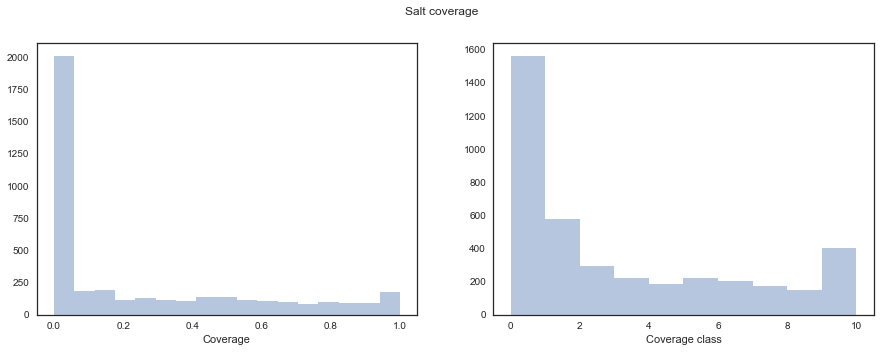

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")
plt.show()

In [8]:
train_df.head()

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


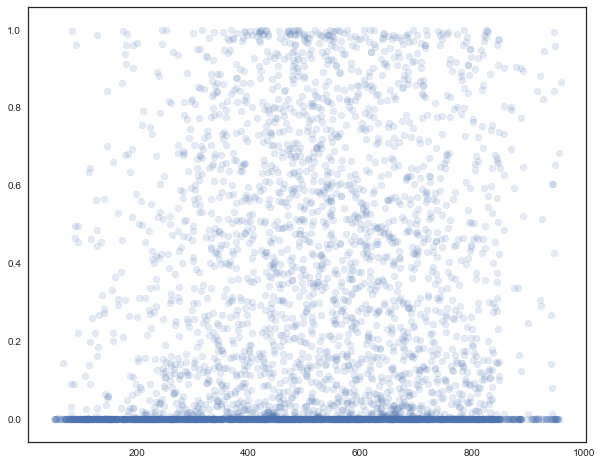

In [9]:
plt.figure(figsize=(10, 8))
plt.scatter(train_df.z, train_df.coverage, alpha=.15)
plt.show()

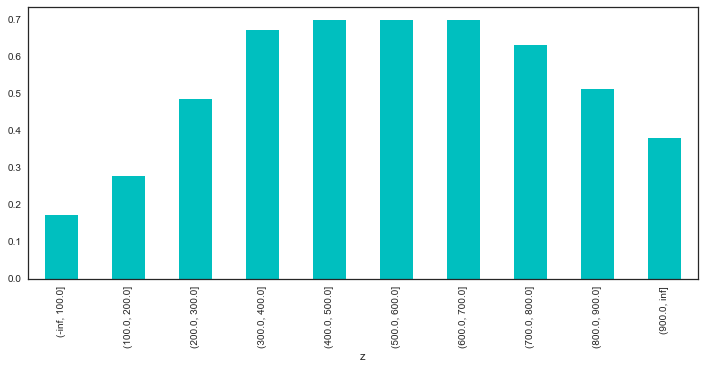

In [10]:
z_cut = pd.cut(train_df.z, [-np.Inf, 100, 200, 300, 400, 500, 600, 700, 800, 900, np.Inf])
c_cut = pd.cut(train_df.coverage, [-np.Inf, 0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, np.Inf], labels=range(11))
train_df["c1"] = (train_df.coverage > 0).astype("int")
train_df["z_cut"] = z_cut
train_df["c_cut"] = c_cut

z_group = train_df.groupby(z_cut)
(z_group.c1.sum() / z_group.c1.size()).plot(kind="bar", color="c", figsize=(12, 5))
plt.show()

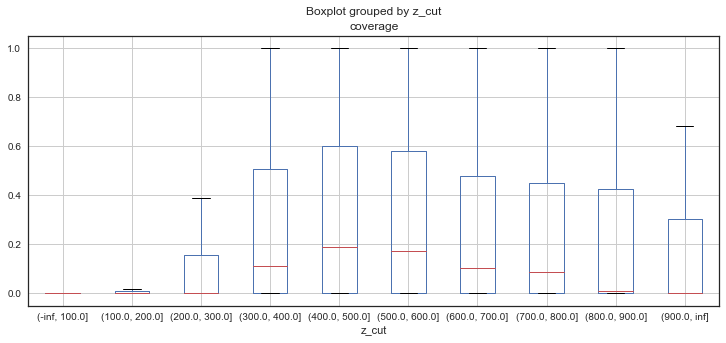

In [11]:
train_df.boxplot(column ="coverage", by="z_cut", figsize=(12, 5))

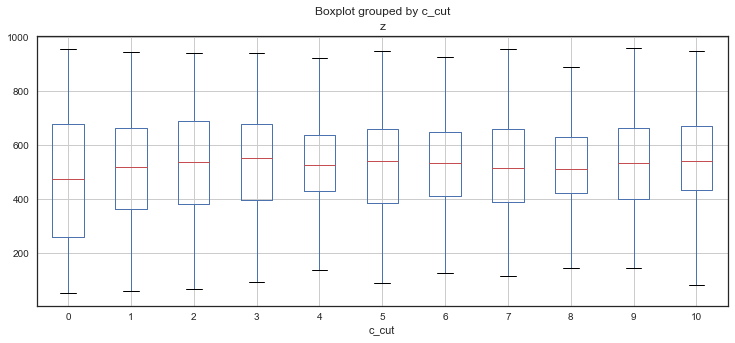

In [12]:
train_df.boxplot(column ="z", by="c_cut", figsize=(12, 5))

## 5fold-split --seed 123

In [13]:
from sklearn.model_selection import StratifiedKFold

In [14]:
X = np.array(train_df.images.tolist()).reshape(-1, img_size_target, img_size_target, 1)
Y = np.array(train_df.masks.tolist()).reshape(-1, img_size_target, img_size_target, 1)
y = train_df.c_cut.values.copy()

In [15]:
skf = StratifiedKFold(n_splits=5, random_state=123)
skf.get_n_splits(X, y)
kfold_index = [ob for ob in skf.split(X, y)]

In [16]:
y.shape

(4000,)

In [17]:
for train_idx, valid_idx in kfold_index:
    print(train_idx.shape, valid_idx.shape)

(3196,) (804,)
(3199,) (801,)
(3200,) (800,)
(3201,) (799,)
(3204,) (796,)


## model

In [18]:
ACTIVATION = "relu"

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation(ACTIVATION)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = Activation(ACTIVATION)(blockInput)
    x = BatchNormalization()(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

# Build model
def _build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = Activation(ACTIVATION)(convm)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = Activation(ACTIVATION)(uconv4)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = Activation(ACTIVATION)(uconv2)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = Activation(ACTIVATION)(uconv1)
    
    uconv1 = Dropout(DropoutRatio/2)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer


def build_model(img_size_target):
    input_layer = Input((img_size_target, img_size_target, 1))
    output_layer = _build_model(input_layer, 16,0.5)

    model = Model(input_layer, output_layer)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])
    return model

## train

In [19]:
exp_code = "007"

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    print("fold:", i)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    log_filepath = "{}-log-resnet-fold-{}.csv".format(exp_code, i)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)

    early_stopping = EarlyStopping(monitor='val_acc', mode = 'max',patience=20, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor='val_acc', mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode = 'max', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    epochs = 200
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model = build_model(img_size_target=101)
    print("build model.")
    
    def train():
        return model.fit(X_train, Y_train,
                         validation_data=[X_valid, Y_valid], 
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                         verbose=200)
    
    %time train()
    break

fold: 0
index.shape: (3196,) (804,)
mode: 007-model-resnet-fold-0.hdf5
log: 007-log-resnet-fold-0.csv
data.shape: (6392, 101, 101, 1) (6392, 101, 101, 1) (804, 101, 101, 1) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/200

Epoch 00001: val_acc improved from -inf to 0.86522, saving model to 007-model-resnet-fold-0.hdf5
Epoch 2/200

Epoch 00002: val_acc improved from 0.86522 to 0.87152, saving model to 007-model-resnet-fold-0.hdf5
Epoch 3/200

Epoch 00003: val_acc did not improve
Epoch 4/200

Epoch 00004: val_acc did not improve
Epoch 5/200

Epoch 00005: val_acc improved from 0.87152 to 0.90817, saving model to 007-model-resnet-fold-0.hdf5
Epoch 6/200

Epoch 00006: val_acc improved from 0.90817 to 0.90983, saving model to 007-model-resnet-fold-0.hdf5
Epoch 7/200

Epoch 00007: val_acc improved from 0.90983 to 0.92874, saving model to 007-model-resnet-fold-0.hdf5
Epoch 8/200

Epoch 00008: val_acc improved from 0.92874 to 0.92958, saving model to 00

## search threshold

In [98]:
def predict_result(model, x_test, img_size_target): # predict both orginal and reflect x
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(a) for a in model.predict(np.array([np.fliplr(x) for x in x_test])).reshape(-1, img_size_target, img_size_target)])
    return preds_test / 2.0

def filter_image(img):
    if img.sum() < 100:
        return np.zeros(img.shape)
    else:
        return img

import glob
glob.glob("./007*.hdf5")

['.\\007-model-resnet-fold-0.hdf5',
 '.\\007-model-resnet-fold-1.hdf5',
 '.\\007-model-resnet-fold-2.hdf5',
 '.\\007-model-resnet-fold-3.hdf5',
 '.\\007-model-resnet-fold-4.hdf5']

In [100]:
thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

def iou(img_true, img_pred):
    i = np.sum((img_true*img_pred) >0)
    u = np.sum((img_true + img_pred) >0)
    if u == 0:
        return u
    return i/u

def iou_metric(imgs_true, imgs_pred):
    num_images = len(imgs_true)
    scores = np.zeros(num_images)
    
    for i in range(num_images):
        if imgs_true[i].sum() == imgs_pred[i].sum() == 0:
            scores[i] = 1
        else:
            scores[i] = (thresholds <= iou(imgs_true[i], imgs_pred[i])).mean()
            
    return scores.mean()

(3196,) (804,)
.\007-model-resnet-fold-0.hdf5


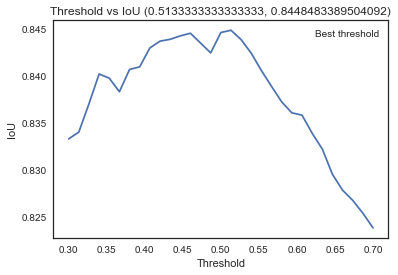

(3199,) (801,)
.\007-model-resnet-fold-1.hdf5


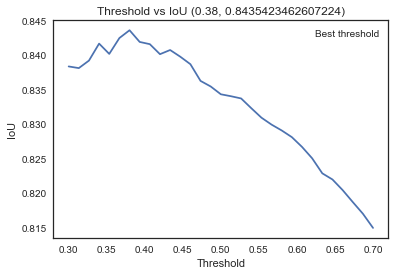

(3200,) (800,)
.\007-model-resnet-fold-2.hdf5


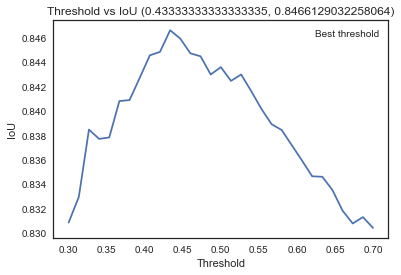

(3201,) (799,)
.\007-model-resnet-fold-3.hdf5


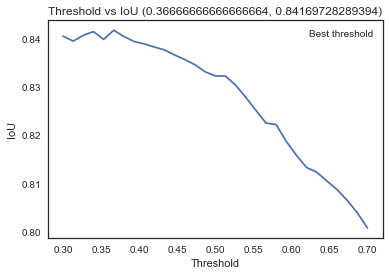

(3204,) (796,)
.\007-model-resnet-fold-4.hdf5


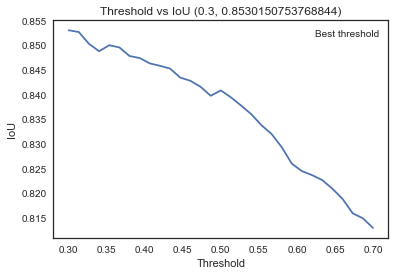

0.8459431893415525 0.0038845992128691514


In [102]:
model_filepaths = [
    '.\\007-model-resnet-fold-0.hdf5',
    '.\\007-model-resnet-fold-1.hdf5',
    '.\\007-model-resnet-fold-2.hdf5',
    '.\\007-model-resnet-fold-3.hdf5',
    '.\\007-model-resnet-fold-4.hdf5'
]

threshold_best_stack = []
iou_best_stack = []

for (train_idx, valid_idx), model_filepath in zip(kfold_index, model_filepaths):
    print(train_idx.shape, valid_idx.shape)
    print(model_filepath)
    
    ## preds_valid
    X_valid = X[valid_idx, :]
    Y_valid = Y[valid_idx, :]
    
    model = load_model(model_filepath)
    preds_valid = predict_result(model, X_valid, img_size_target)
    
    ## Scoring for last model
    thresholds = np.linspace(0.3, 0.7, 31)
    ious = np.array([iou_metric(Y_valid.reshape((-1, img_size_target, img_size_target)), [filter_image(img) for img in preds_valid > threshold]) for threshold in tqdm_notebook(thresholds)])
    
    threshold_best_index = np.argmax(ious) 
    iou_best = ious[threshold_best_index]
    threshold_best = thresholds[threshold_best_index]
    
    threshold_best_stack.append(threshold_best)
    iou_best_stack.append(iou_best)

    plt.plot(thresholds, ious)
    plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
    plt.legend()
    plt.show()
    
print(np.mean(iou_best_stack), np.std(iou_best_stack))

## predict test

threshold_best_stack = [0.5133333333333333, 0.38, 0.43333333333333335, 0.36666666666666664, 0.3]

In [2]:
img_size_target = 101

In [3]:
def predict_result(model, x_test, img_size_target): # predict both orginal and reflect x
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(a) for a in model.predict(np.array([np.fliplr(x) for x in x_test])).reshape(-1, img_size_target, img_size_target)])
    return preds_test / 2.0

def filter_image(img):
    if img.sum() < 100:
        return np.zeros(img.shape)
    else:
        return img

model_filepaths = [
    '.\\007-model-resnet-fold-0.hdf5',
    '.\\007-model-resnet-fold-1.hdf5',
    '.\\007-model-resnet-fold-2.hdf5',
    '.\\007-model-resnet-fold-3.hdf5',
    '.\\007-model-resnet-fold-4.hdf5'
]

threshold_best_stack = [0.5133333333333333, 0.38, 0.43333333333333335, 0.36666666666666664, 0.3]

In [4]:
# Loading of training/testing ids and depths

train_df = pd.read_csv("./data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [5]:
x_test = np.array([(np.array(load_img("./data/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [6]:
preds_test = np.zeros((18000,101,101))
preds_test.shape

(18000, 101, 101)

In [7]:
# bld
for model_filepath, threshold_best in zip(model_filepaths, threshold_best_stack):
    print(model_filepath, threshold_best)
    model = load_model(model_filepath)
    pred_temp = predict_result(model, x_test, img_size_target)
    print(pred_temp.shape, preds_test.shape)
    preds_test += pred_temp
    
preds_test = preds_test > sum(threshold_best_stack)

.\007-model-resnet-fold-0.hdf5 0.5133333333333333
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-1.hdf5 0.38
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-2.hdf5 0.43333333333333335
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-3.hdf5 0.36666666666666664
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-4.hdf5 0.3
(18000, 101, 101) (18000, 101, 101)


In [11]:
# vote
for model_filepath, threshold_best in zip(model_filepaths, threshold_best_stack):
    print(model_filepath, threshold_best)
    model = load_model(model_filepath)
    pred_temp = (predict_result(model, x_test, img_size_target) > threshold_best)
    print(pred_temp.shape, preds_test.shape)
    preds_test += pred_temp
    
preds_test = preds_test >= 3

.\007-model-resnet-fold-0.hdf5 0.5133333333333333
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-1.hdf5 0.38
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-2.hdf5 0.43333333333333335
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-3.hdf5 0.36666666666666664
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-4.hdf5 0.3
(18000, 101, 101) (18000, 101, 101)


In [9]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_encode2(im):
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [10]:
import time
t1 = time.time()
pred_dict = {idx: rle_encode2(filter_image(preds_test[i])) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

Usedtime = 8.09692645072937 s


In [11]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('./result/007-submission-bld.csv')

In [12]:
sub.head(10)

,rle_mask
id,
353e010b7b,
5439dbbddf,
71bab9f311,
52551f7a80,
512d8d9997,3 1 102 1 104 1 203 5 304 3 405 6 506 3 510 1 ...
64dba827d6,
0a3a8a5f37,
329563756f,1 4948 4950 100 5051 99 5152 98 5253 97 5354 9...
f6cba2e890,


In [18]:
sub.head(10)

,rle_mask
id,
353e010b7b,
5439dbbddf,
71bab9f311,
52551f7a80,
512d8d9997,94 8 194 9 296 8 396 9 495 11 595 12 696 12 79...
64dba827d6,
0a3a8a5f37,
329563756f,1 9077 9084 91 9189 83 9293 76 9394 71 9495 66...
f6cba2e890,
